<a href="https://colab.research.google.com/github/AkashBhardwaj9078/Demo_git_work/blob/main/breast_cancer_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
100% 194M/195M [00:07<00:00, 27.5MB/s]
100% 195M/195M [00:07<00:00, 27.9MB/s]


In [2]:
!unzip /content/breast-ultrasound-images-dataset.zip

Archive:  /content/breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflat

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [4]:

from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [6]:
dataset=image_dataset_from_directory(
    "/content/Dataset_BUSI_with_GT",
     color_mode="rgb",
    image_size=(256,256),
    batch_size=32,
    label_mode="categorical",
    shuffle=True,
    seed=42,



)

Found 1578 files belonging to 3 classes.


In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [8]:
ds_train,ds_val,ds_test=splits(dataset,0.6,0.2,0.2)

In [9]:
import numpy as np
class_names=dataset.class_names
class_names

['benign', 'malignant', 'normal']

In [10]:
def show_images(ds):
  for img,labels in ds_train.take(2):
      plt.figure(figsize=(18,15))
      for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i].numpy().astype("uint32"))
        plt.axis("off")
        plt.title(class_names[np.argmax(labels[i])])



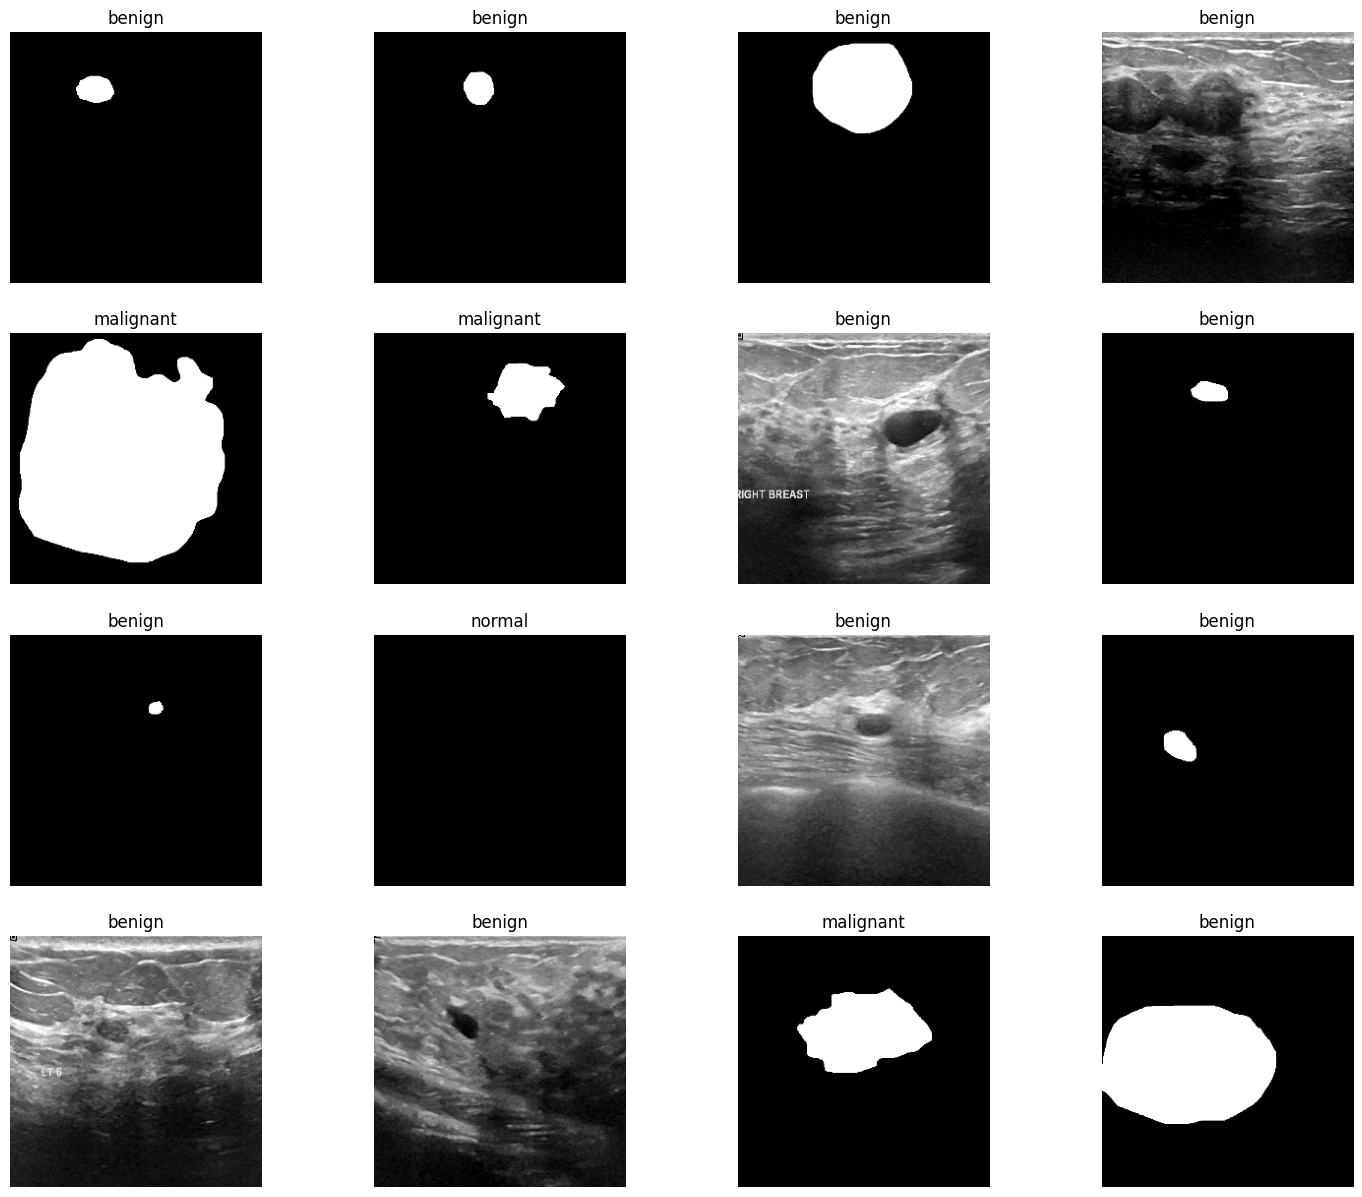

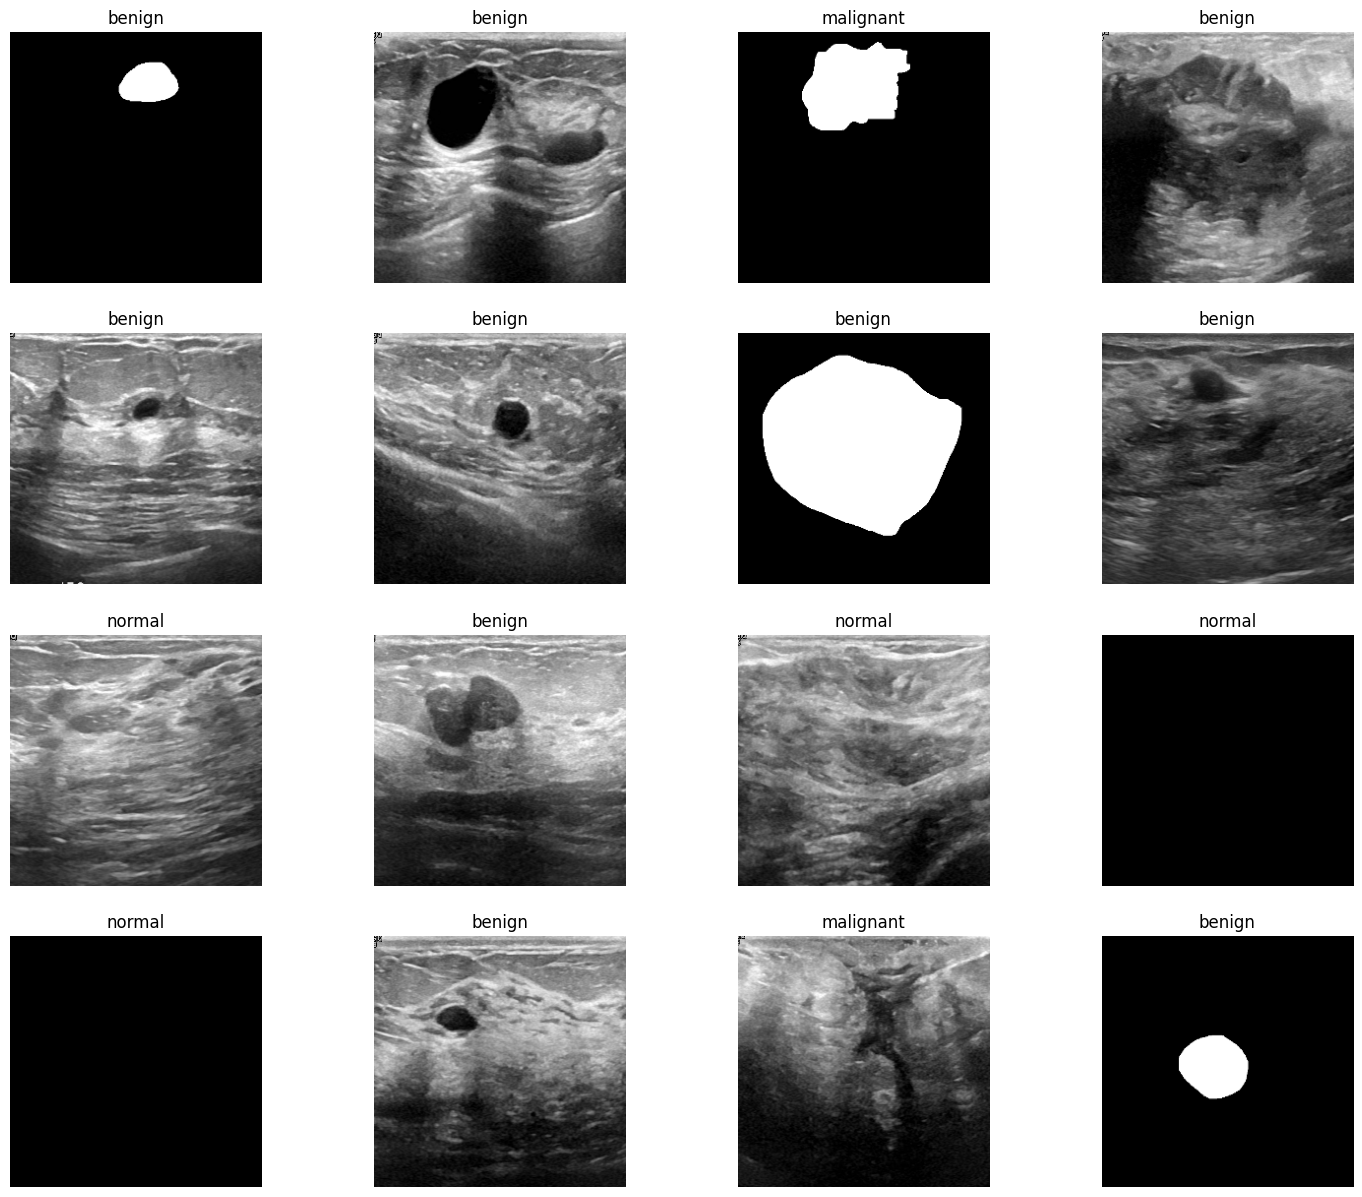

In [11]:
show_images(ds_train)

In [12]:
import tensorflow as tf

In [13]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(256, 256),
       Rescaling(1./255),
])
def resize_rescale(image,label):
  return resize_rescale_layers(image,training=False)

In [14]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [15]:

def box(lam):
  rx=tf.cast(tfp.distributions.Uniform(0,256).sample(1)[0],tf.int32)
  ry=tf.cast(tfp.distributions.Uniform(0,256).sample(1)[0],tf.int32)

  rw=tf.cast(256*tf.math.sqrt(1-lam),tf.int32)
  rh=tf.cast(256*tf.math.sqrt(1-lam),tf.int32)

  rx=tf.clip_by_value(rx-rw//2,0,255)
  ry=tf.clip_by_value(ry-rh//2,0,255)

  rx_t=tf.clip_by_value(rx+rw//2,0,255)
  ry_t=tf.clip_by_value(ry+rh//2,0,255)

  rw=rx_t-rx
  if rw==0:
    rw=1
  rh=ry_t-ry
  if rh==0:
    rh=1


  return rx,ry,rw,rh





In [16]:
def cutmix(train_img1,train_img2):

  (img1,lab1),(img2,lab2)=train_img1,train_img2
  lam=tfp.distributions.Beta(0.3,0.3).sample(1)[0]
  rx,ry,rw,rh=box(lam)
  crp_img1=tf.image.crop_to_bounding_box(img1,ry,rx,rh,rw)
  pad_img1=tf.image.pad_to_bounding_box(crp_img1,rx,ry,256,256)

  crp_img2=tf.image.crop_to_bounding_box(img2,ry,rx,rh,rw)
  pad_img2=tf.image.pad_to_bounding_box(crp_img2,rx,ry,256,256)
  image=img1-pad_img1+pad_img2

  lamda=tf.cast(1-((rw*rh)/(256*256)),tf.float32)

  label=lamda*lab1+(1-lamda)*lab2
  return image,label

In [17]:
aug_layer=tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.2)
    ]
)

def augment(image,label):
  return aug_layer(image,training=False),label

In [18]:
train_dataset1=ds_train.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset2=ds_train.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
cutmix_data=tf.data.Dataset.zip((train_dataset1,train_dataset2))
cutmix_data=cutmix_data.map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
cutmix_data

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

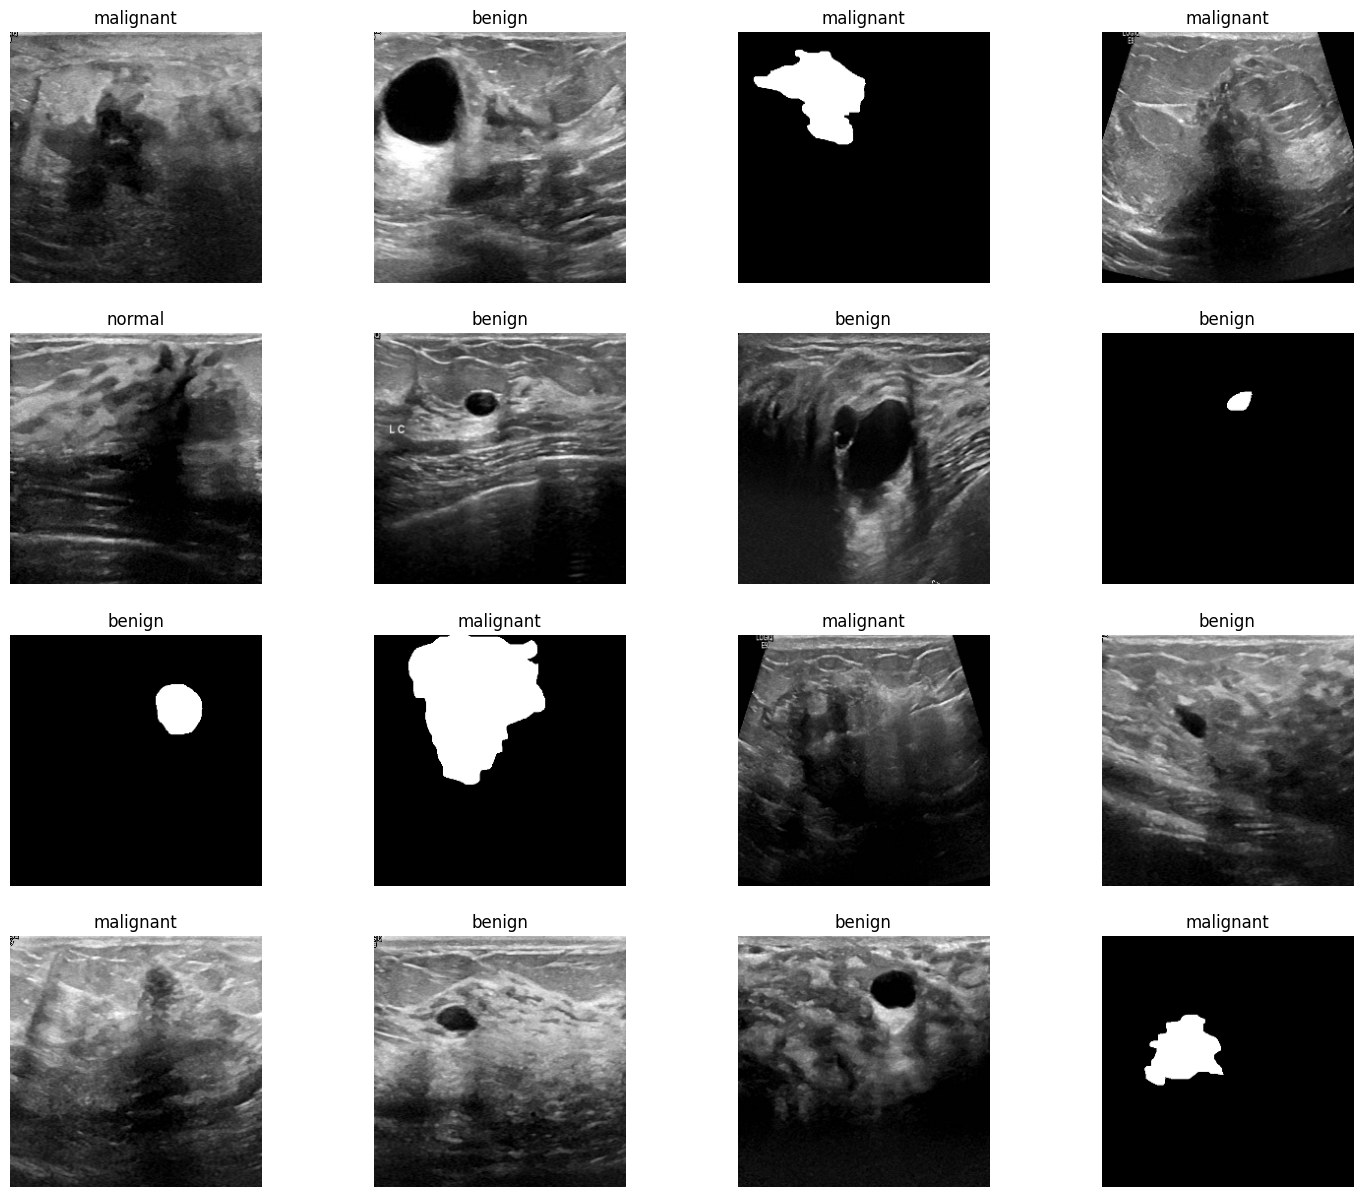

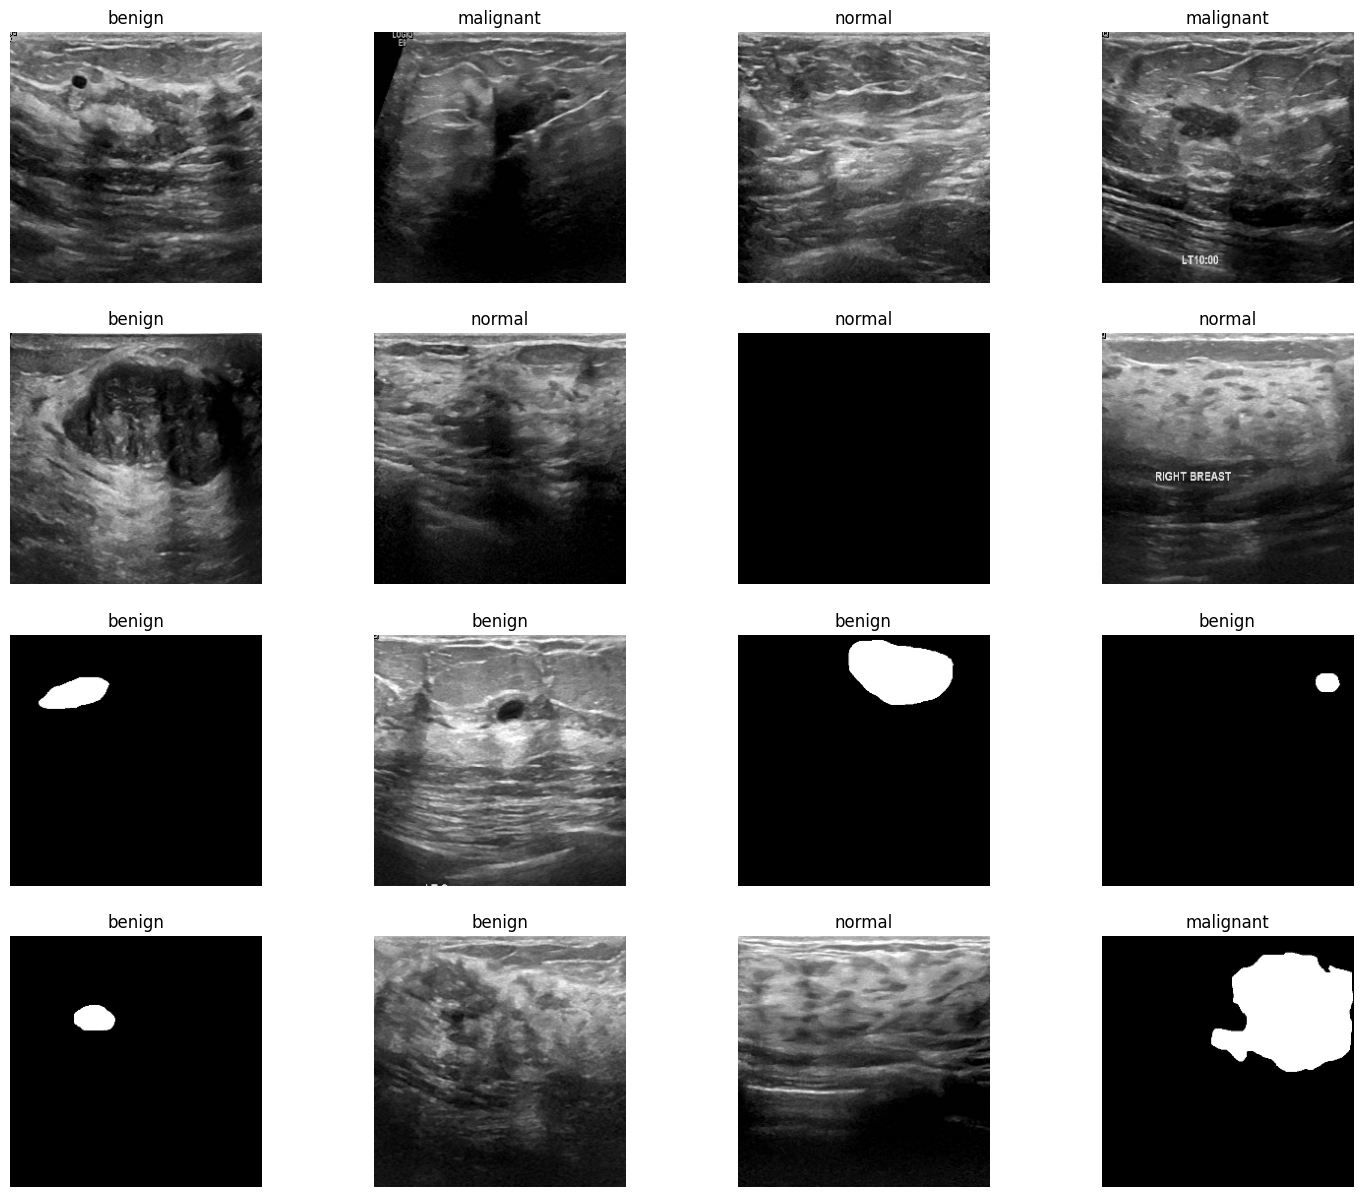

In [19]:
show_images(cutmix_data.shuffle(1024))

In [20]:
train_dataset1=ds_train.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset2=ds_train.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
mixed_data=tf.data.Dataset.zip((train_dataset1,train_dataset2))
mixed_data=mixed_data.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
mixed_data

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)))>

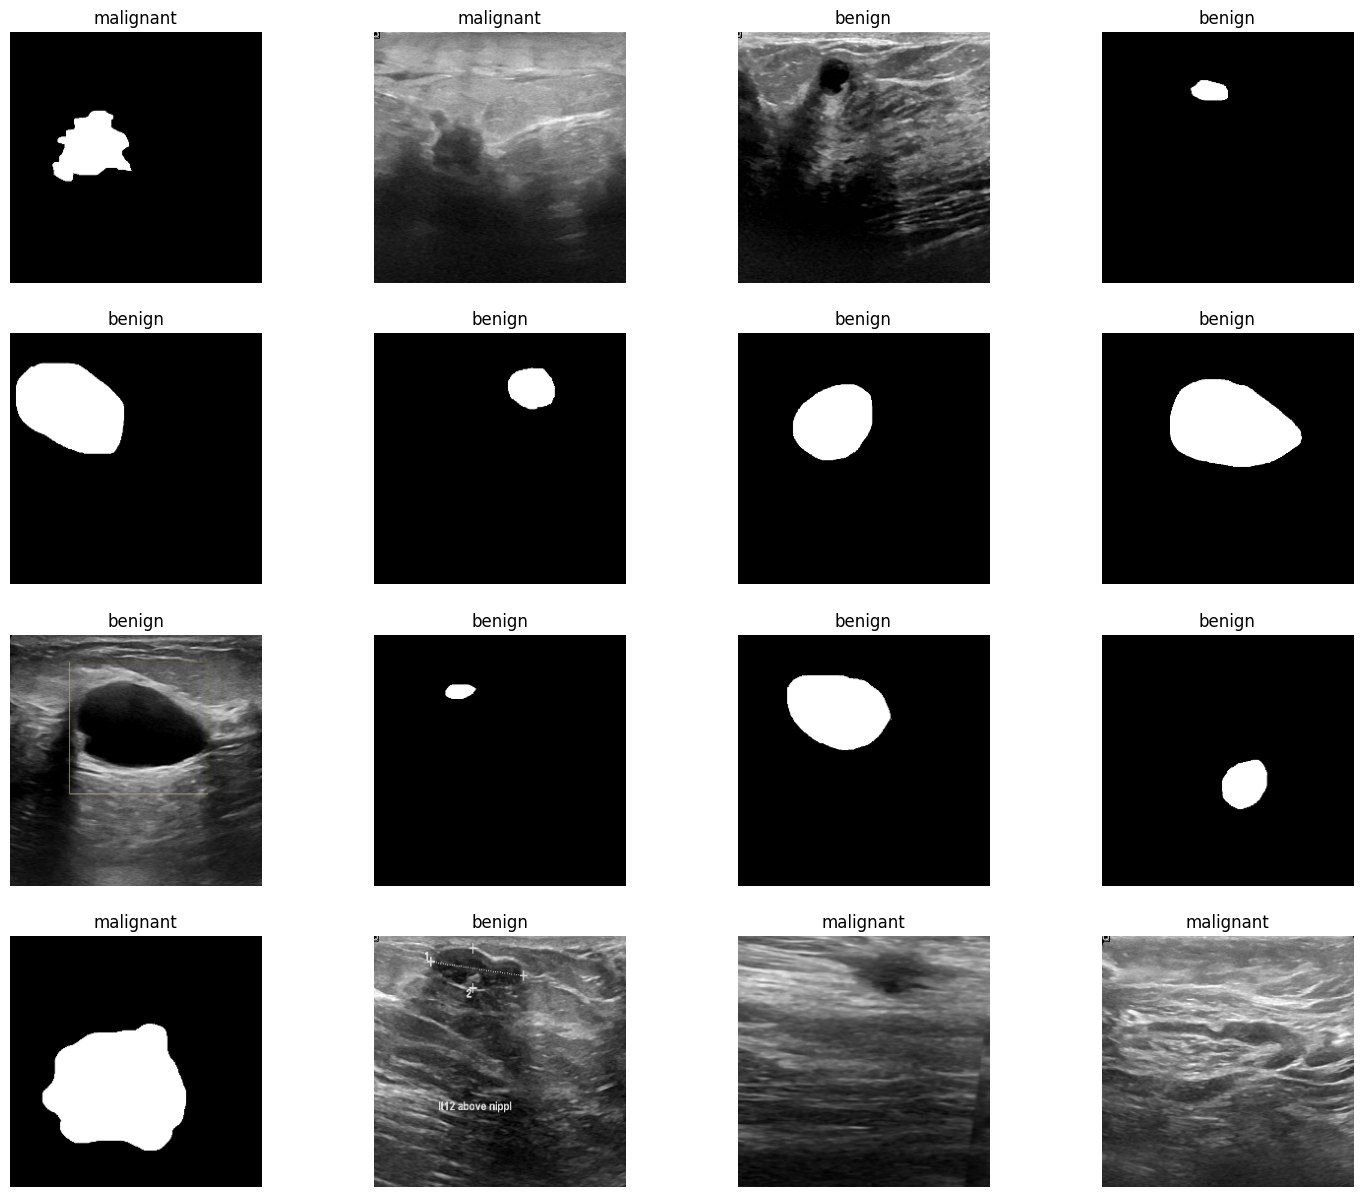

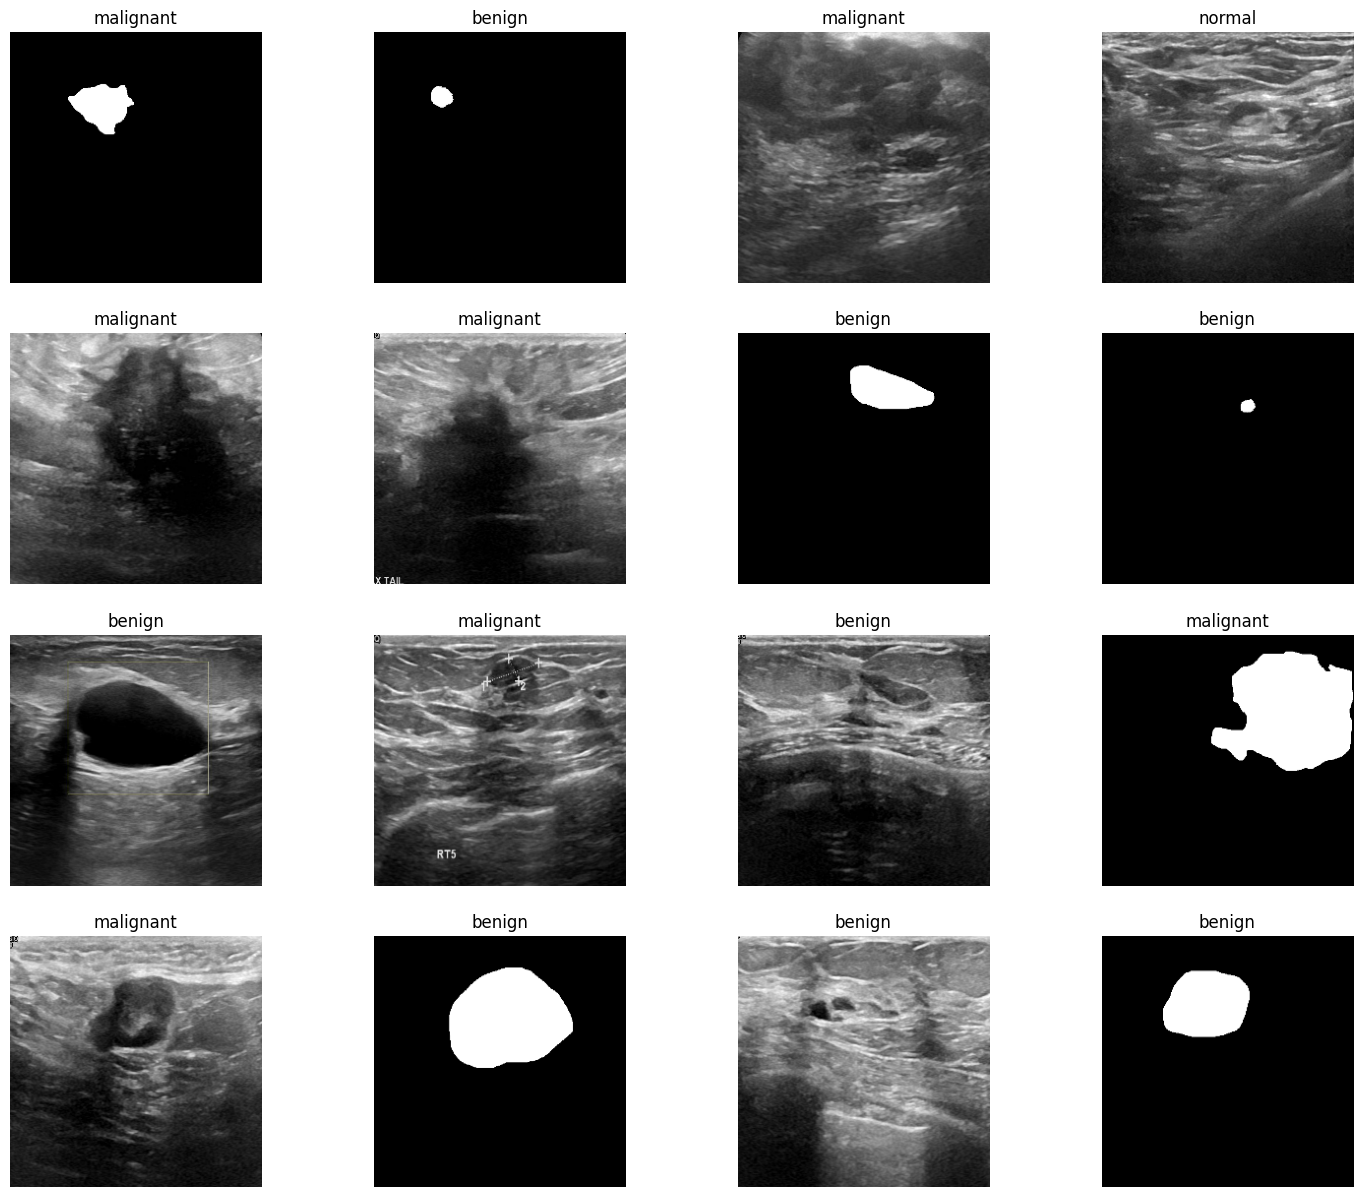

In [21]:
show_images(mixed_data.shuffle(1024))

In [22]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (256, 256, 3)),

    Conv2D(filters = 6 , kernel_size =5 , strides = 2 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(0.0001)),
    BatchNormalization(),
    MaxPool2D (pool_size = (2,2), strides= 2*2),
    Dropout(rate = 0.2 ),

    Conv2D(filters = 6*2 + 4, kernel_size = 5, strides=2, padding='valid',
          activation = 'relu', kernel_regularizer = L2(0.0001)),
    BatchNormalization(),
    MaxPool2D (pool_size = (2,2), strides= 2*2),

    Flatten(),

    Dense( 1024, activation = "relu", kernel_regularizer = L2(0.0001)),
    BatchNormalization(),
    Dropout(rate = 0.2),

    Dense( 2048, activation = "relu", kernel_regularizer = L2(0.0001)),
    BatchNormalization(),

    Dense(3, activation = "sigmoid"),

])

In [23]:
lenet_model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
)
model_checkpoint = ModelCheckpoint(
    filepath="/content/model.h5",
    monitor="val_loss",
    save_best_only=True,
)


In [25]:
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 6)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 16)       

In [26]:
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


In [27]:
lenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy",
    metrics=metrics
)

In [28]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(256,256, 3),
    )

71686520/71686520 [==============================] - 3s 0us/step


In [ ]:
hist=lenet_model.fit(ds_train,validation_data=ds_test,epochs=20,verbose=1,callbacks=[model_checkpoint,early_stopping])

Epoch 1/20
30/30 [==============================] - 29s 935ms/step - loss: 1.4753 - tp: 754.0000 - fp: 712.0000 - tn: 1208.0000 - fn: 206.0000 - accuracy: 0.6812 - precision: 0.5143 - recall: 0.7854 - auc: 0.7940 - val_loss: 3.0974 - val_tp: 147.0000 - val_fp: 207.0000 - val_tn: 389.0000 - val_fn: 151.0000 - val_accuracy: 0.5996 - val_precision: 0.4153 - val_recall: 0.4933 - val_auc: 0.5148
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 26s 840ms/step - loss: 1.1055 - tp: 809.0000 - fp: 635.0000 - tn: 1285.0000 - fn: 151.0000 - accuracy: 0.7271 - precision: 0.5602 - recall: 0.8427 - auc: 0.8454 - val_loss: 1.3073 - val_tp: 215.0000 - val_fp: 199.0000 - val_tn: 397.0000 - val_fn: 83.0000 - val_accuracy: 0.6846 - val_precision: 0.5193 - val_recall: 0.7215 - val_auc: 0.7359
Epoch 3/20
30/30 [==============================] - 29s 931ms/step - loss: 0.9534 - tp: 837.0000 - fp: 604.0000 - tn: 1316.0000 - fn: 123.0000 - accuracy: 0.7476 - precision: 0.5808 - recall: 0.8719 - auc: 0.8666 - val_loss: 1.3324 - val_tp: 240.0000 - val_fp: 186.0000 - val_tn: 410.0000 - val_fn: 58.0000 - val_accuracy: 0.7271 - val_precision: 0.5634 - val_recall: 0.8054 - val_auc: 0.8019
Epoch 4/20
30/30 [==============================] - 27s 861ms/step - loss: 0.9212 - tp: 851.0000 - fp: 633.0000 - tn: 1287.0000 - fn: 109.0000 - accuracy: 0.7424 - precision: 0.5735 - recall: 0.8865 - auc: 0.8815 - val_loss: 

In [ ]:
backbone.trainable=False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (256, 256,3)),
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense( 512, activation = "relu"),
    BatchNormalization(),
    Dense( 512, activation = "relu"),
    Dense( 3, activation = "softmax"),

    ])

In [ ]:
pretrained_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               918016    
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                      

In [ ]:


metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=2)]

In [ ]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = 0.0001),
  loss = tf.keras.losses.CategoricalCrossentropy(),
  metrics = metrics,
)

In [ ]:
history = pretrained_model.fit(
  ds_train,
  validation_data=ds_test,

  epochs = 20,
  verbose = 1,

)


Epoch 1/20
30/30 [==============================] - 386s 12s/step - loss: 0.5506 - categorical_accuracy: 0.7604 - top_k_categorical_accuracy: 0.9115 - val_loss: 0.7220 - val_categorical_accuracy: 0.8490 - val_top_k_categorical_accuracy: 0.9430
Epoch 2/20
30/30 [==============================] - 418s 14s/step - loss: 0.2606 - categorical_accuracy: 0.9094 - top_k_categorical_accuracy: 0.9833 - val_loss: 0.6403 - val_categorical_accuracy: 0.8658 - val_top_k_categorical_accuracy: 0.9564
Epoch 3/20
30/30 [==============================] - 377s 13s/step - loss: 0.2128 - categorical_accuracy: 0.9271 - top_k_categorical_accuracy: 0.9885 - val_loss: 0.5694 - val_categorical_accuracy: 0.8826 - val_top_k_categorical_accuracy: 0.9631
Epoch 4/20
30/30 [==============================] - 418s 14s/step - loss: 0.1704 - categorical_accuracy: 0.9469 - top_k_categorical_accuracy: 0.9917 - val_loss: 0.5210 - val_categorical_accuracy: 0.8624 - val_top_k_categorical_accuracy: 0.9832
Epoch 5/20
30/30 [======

KeyboardInterrupt: 

NameError: name 'history' is not defined